<a href="https://colab.research.google.com/github/ZainShaikh-12/AIAgents/blob/main/LangGraphAgentProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Install Requried packages

In [ ]:
%pip install -q -U langchain langgraph langchain_community langchain-chroma chromadb langchain-groq langchainhub langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.1 MB/s eta 0

Now Initilized the secret keys

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')




In [ ]:
import os
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['lANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = "Langgraph_AgentProject"
os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

# Loading Documents

In [ ]:
from langchain.document_loaders import WebBaseLoader
import bs4

bs4_strainer = bs4.SoupStrainer(class_=("post-tile", "post-header", "post-content"))
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(web_paths=urls).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(docs_list)

# Splitting Documents


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 200,
)
splited_docs = text_splitter.split_documents(docs_list)
splited_docs

# Storing Documents and Embedding

In [ ]:
%pip install -q -U langchain-google-genai

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma

embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",google_api_key=GEMINI_API_KEY)
vectorstore = Chroma(
    collection_name="langgraph-agent",
    embedding_function=embedding,
)

# Reterive Document

In [ ]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

vectorstore.add_documents(splited_docs)

chroma_index_wrapper = VectorStoreIndexWrapper(vectorstore=vectorstore)

retriever = vectorstore.as_retriever()
retriever
# retrivered_docs = retriever.invoke("koshari")
# retrivered_docs

# Tools setup

In [ ]:
%pip install -q -U  wikipedia

# Create Router

In [ ]:

from pydantic import BaseModel, Field
from typing import Literal

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore","wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore",
    )

# Initilize LLM Model

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="Llama-3.1-70b-Versatile",api_key=GROQ_API_KEY)
# llm.bind_tools(tools=tools)
# llm.invoke("what is food")



# Interigate the Router with LLM

In [ ]:
Structured_llm_router=llm.with_structured_output(RouteQuery)
Structured_llm_router

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78e40dac5150>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78e40dac70d0>, model_name='Llama-3.1-70b-Versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route a user query to the most relevant datasource.', 'parameters': {'properties': {'datasource': {'description': 'Given a user question choose to route it to wikipedia or a vectorstore', 'enum': ['vectorstore', 'wiki_search'], 'type': 'string'}}, 'required': ['datasource'], 'type': 'object'}}}], 'tool_choice': {'type': 'function', 'function': {'name': 'RouteQuery'}}}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.RouteQuery'>])

# Now Create a prompt template to guide our LLM model

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search"""



route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)


# Now Chain the route_prompt and RouterQuery

In [ ]:
question_router = route_prompt | Structured_llm_router

print(question_router.invoke({"question": "What are the types of agent memory?"}))

print(question_router.invoke({"question": "i am looking for beef recipies"}))


datasource='vectorstore'
datasource='wiki_search'


In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

wikipedia = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia)

## Create AiAgent application using langgraph

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    question: question
    generation: LLM generation
    documents: list of documents
  """

  question: str
  generation: str
  documents: List[str]

#Create a fuction that retrive data from vectorstore

In [ ]:
from langchain.schema import Document

def retrieve(state):
  """
    Retrive documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

  print("---Retrieve---")
  questions = state["question"]

  documents = retriever.invoke(questions)
  return {"documents":documents,"question":questions}


# Create a function that Retrieve data from wikipedia

In [ ]:
def wiki_search(state):
  """
    wiki search based on the re-phase question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Update documents key with appended web results
    """

  print("---wikiRetrieve---")
  question = state["question"]
  print(question)
  docs = wikipedia_tool.invoke({"query":question})
  wiki_result = docs
  wiki_result = Document(page_content=wiki_result)

  return {"documents":wiki_result,"question":question}


# Create a Route Function

In [ ]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [ ]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

# Langgraph flow by edges

In [ ]:
from langgraph.graph import END,StateGraph,START

builder = StateGraph(GraphState)
# Define nodes
builder.add_node("wiki_search",wiki_search)
builder.add_node("retrieve",retrieve)

# Build the graph
builder.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve"
    },
)
builder.add_edge("retrieve",END)
builder.add_edge("wiki_search",END)

graph = builder.compile()

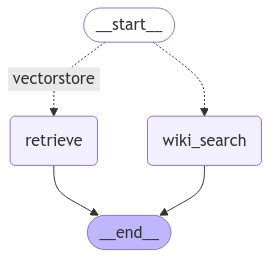

In [ ]:
from IPython.display import display, Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

  pass

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
    #     # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    # pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---
"Node 'retrieve':"
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview In a LLM-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components:')


In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "who is sharukh khan?"
}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikiRetrieve---
who is sharukh khan?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10')
